<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/expml/blob/main/pytorch_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying image classifier with pytorch


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torchvision # loading datasets
import torchvision.transforms as transforms # transformations on data
import torch.nn as nn # basic building block of the NNs
import torch.nn.functional as F # convolution funcs like ReLU
import torch.optim as optim # optimizer

In [2]:
mean_std_vector = (0.5,0.5,0.5) # images end up in the form [-1,1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_std_vector, mean_std_vector)
])

BATCH_SIZE = 4
NUM_WORKERS = 2

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
train_set = torchvision.datasets.CIFAR10(
    root = './data',
    download=True,
    train = True,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_set = torchvision.datasets.CIFAR10(
    root = './data',
    download=True,
    train = False,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

Files already downloaded and verified
Files already downloaded and verified


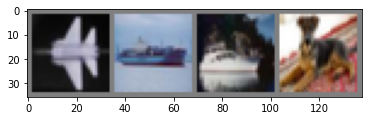

plane ship ship dog


In [10]:
def imshow(img):
  img = img / 2 + 0.5 # unnnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
join_char =  ' '
print(join_char.join('%s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [14]:
start.record()

for epoch in range(2): 
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad() # zero the parameter gradient

    # forward + backward + optimize

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print stats
    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch+1}, {i+1}] loss = {running_loss/2000}')
      running_loss = 0.0

end.record()
torch.cuda.synchronize()

print(f'Finished training {start.elapsed_time(end)}')

[1, 2000] loss = 2.199765282511711
[1, 4000] loss = 1.8350884461402892
[1, 6000] loss = 1.6664179444611074
[1, 8000] loss = 1.5586811318546534
[1, 10000] loss = 1.5267609649822116
[1, 12000] loss = 1.5023407166525722
[2, 2000] loss = 1.394192719683051
[2, 4000] loss = 1.392813930079341
[2, 6000] loss = 1.3465335849374533
[2, 8000] loss = 1.3271599042974414
[2, 10000] loss = 1.300208114758134
[2, 12000] loss = 1.2735910660363734
Finished training 122099.53125


In [15]:
# save
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
# reload
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

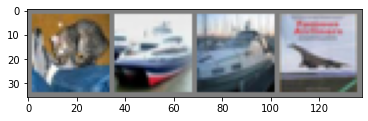

GroundTruth:  cat ship ship plane


In [17]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat car ship ship


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
